In [1]:
!nvidia-smi

Sun Dec 10 05:39:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# prompt: CPUのコア数をしらべて
import os
os.cpu_count()

2

In [3]:
class Config:
    name = "exp044" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される

    # Colab Env
    upload_from_colab = False
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/ucbo"

DEBUG = False


In [4]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys


In [5]:
COLAB = "google.colab" in sys.modules
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.5.16-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [6]:
if COLAB:
    print("This environment is Google Colab")

    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive')


    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

    # set dirs
    DRIVE = Config.drive_path
    EXP = Config.name
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP)
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT, SCRIPT, OUTPUT, OUTPUT_EXP]:
        os.makedirs(d, exist_ok=True)

    # if not os.path.isfile(os.path.join(INPUT, "train.csv")):
    #     # load dataset
    #     ! kaggle competitions download -c UBC-OCEAN -p $INPUT
    #     unzip_file = os.path.join(INPUT, 'UBC-OCEAN.zip')
    #     ! unzip $unzip_file -d $INPUT



This environment is Google Colab


In [8]:
%%time
if not DEBUG:
    # tmp fileに直接ダウンロードする
    TMP = '/content/tmp'
    INPUT = '/content/tmp'
    !mkdir $TMP
    files = [
        'tyabanoamami/ucbo-colab-dataset', 'hmendonca/efficientnet-pytorch',
            #  'pjmathematician/ucbo-tiles-256-1', #'tyabanoamami/ucbo-clean-images',
            #  'pjmathematician/ucbo-tiles-256-2', 'pjmathematician/ucbo-tiles-256-3',
            #  'pjmathematician/ucbo-tiles-256-4', 'pjmathematician/ucbo-tiles-256-5',
        'jirkaborovec/tiles-of-cancer-2048px-scale-0-25'
            ]
    for f in files:
        !kaggle datasets download -d $f -p $TMP
        t = f.split('/')[1]
        unzip_file = os.path.join(TMP, f'{t}.zip')
        unzip_file_ = TMP + '/' + t
        INPUT_ = INPUT + '/' + t
        ! unzip $unzip_file -d $unzip_file_
        # !mv $unzip_file_ $INPUT_
        !rm -rf $unzip_file

mkdir: cannot create directory ‘/content/tmp’: File exists
 22% 88.0M/399M [00:02<00:08, 37.5MB/s]
User cancelled operation
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 86, in main
    if out is not None:
KeyboardInterrupt
^C
Archive:  /content/tmp/ucbo-colab-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/tmp/ucbo-colab-dataset.zip or
        /content/tmp/ucbo-colab-dataset.zip.zip, and cannot find /content/tmp/ucbo-colab-dataset.zip.ZIP, period.
  2% 12.0M/688M [00:00<00:06, 112MB/s]
User cancelled operation
Archive:  /content/tmp/efficientnet-pytorch.zip
  End-of-central-directory s

# Library

In [7]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install timm

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-11isiyjc
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-11isiyjc
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done


In [8]:
import os
import sys
sys.path = [
    os.path.join(INPUT, 'efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'),
] + sys.path

In [9]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm.notebook import tqdm
from sklearn.metrics import balanced_accuracy_score
import timm


In [10]:
# df = pd.read_csv('/content/drive/MyDrive/kaggle/ucbo/Input/tiles-of-cancer-2048px-scale-0-25/train.csv')
# df[df.image_id==int(folders[1].split('/')[-1])].is_tma.values
# from glob import glob
# folders = glob('/content/drive/MyDrive/kaggle/ucbo/Input/tiles-of-cancer-2048px-scale-0-25/*')
# for f in sorted(folders, key=lambda x: int(x.split('/')[-1]) if x.split('/')[-1]!='train.csv' else 999999)[:-1]:
#     tma=False
#     if df[df.image_id==int(f.split('/')[-1])].is_tma.values[0]:
#         tma=True
#     print(f.split('/')[-1], len(glob(f+'/*png')), tma)

# Config

In [11]:
data_dir = os.path.join(INPUT, 'tiles-of-cancer-2048px-scale-0-25')
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')
labels = ['CC', 'EC', 'HGSC', 'LGSC', 'MC', 'Other'] #df_train['label'].unique().tolist() + ['Other']
l2n = {v: k for k, v in enumerate(labels)}
n2l = {k: v for k, v in enumerate(labels)}

kernel_type = Config.name

enet_type = 'efficientnet_b0'
fold = 0
tile_size = 512
image_size = 512
n_tiles = 4 if DEBUG else 9
batch_size = 4
num_workers = os.cpu_count()
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 1 if DEBUG else 20
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

import random
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch()

/content/drive/MyDrive/kaggle/ucbo/Input/tiles-of-cancer-2048px-scale-0-25/train_images


# Create Folds

In [12]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['label'])):
    df_train.loc[valid_idx, 'fold'] = i
# df_train.head()

In [13]:
def get_image_path(image_id:int):
    # if 4 <= image_id <= 15188:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-1')
    # elif 15209 <= image_id <= 30515:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-2')
    # elif 30539 <= image_id <= 38687:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-3')
    # elif 38849 <= image_id <= 65300:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-4')
    # elif 65371 <= image_id <= 65533:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-5')
    path = os.path.join(INPUT, 'tiles-of-cancer-2048px-scale-0-25')
    return os.path.join(path, str(image_id))

df_train['tile_path'] = df_train['image_id'].apply(lambda x: get_image_path(x))

# df_train['total_tiles'] = df_train['tile_path'].apply(lambda x: len(os.listdir(x)))
# df_train.head()

# train['clean_tiles'] = train['image_id'].apply(lambda x: len(d[x]))/train['total_tiles']
# train.head()

# Model

In [14]:
# prompt: class enetv2(nn.Module):     def __init__(self, backbone, out_dim):         super(enetv2, self).__init__()         self.enet = enet.EfficientNet.from_name(backbone)         self.enet.load_state_dict(torch.load(pretrained_model[backbone]))          self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)         self.enet._fc = nn.Identity()      def extract(self, x):         return self.enet(x)      def forward(self, x):         x = self.extract(x)         x = self.myfc(x)         return xこのモデルをtimmを使って書き直してください

class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = timm.create_model(backbone, pretrained=True)
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x


In [15]:
# model = enetv2('efficientnet_b0', 6)
# model = timm.create_model('efficientnet_b0', pretrained=True)
# model.__dict__['default_cfg']

# Dataset

In [16]:
import joblib
good_images = joblib.load(os.path.join(OUTPUT, 'bw_checker/good_images.pkl'))

In [25]:
def get_tiles(paths, tma, tile_size):
    ret = []
    for path in paths:
        # PNGファイルを読み込み
        image = PIL.Image.open(path)
        if tma:
            image = image.resize((tile_size, tile_size))

        # Pillow ImageオブジェクトをNumPy配列に変換
        image_array = np.array(image)
        ret.append(image_array)
    return ret


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id

        if row.is_tma:
            tile_size = int(self.image_size*0.5)
            ntiles = (int(np.sqrt(self.n_tiles))*2)**2
        else:
            tile_size = self.image_size
            ntiles = self.n_tiles

        try:
            tiles = good_images[img_id]
        except:
            files = os.listdir(row.tile_path)
            tiles = [row.tile_path + f'/{e}' for e in files]
        if DEBUG:
            tiles = [t.replace('/content/tmp', INPUT) for t in tiles]
        n_imgs = len(tiles)
        tiles = get_tiles(tiles, row.is_tma, tile_size)


        if self.rand:
            idxes = np.random.choice(list(range(ntiles)), ntiles, replace=False)
        else:
            idxes = list(range(ntiles))



        n_row_tiles = int(np.sqrt(ntiles))
        images = np.zeros((tile_size * n_row_tiles, tile_size * n_row_tiles, 3))



        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w

                # fill all tiles(exp014)
                try:
                    this_img = tiles[idxes[i%n_imgs]]
                except:
                    this_img = np.ones((tile_size, tile_size, 3)).astype(np.uint8) * 255

                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * tile_size
                w1 = w * tile_size
                images[h1:h1+tile_size, w1:w1+tile_size] = this_img


        images = images.astype(np.float32)
        images = images.transpose(2, 0, 1)

        # default label
        label = np.zeros(out_dim).astype(np.float32)
        label[l2n[row.label]] = 1.


        return torch.tensor(images), torch.tensor(label)


# Augmentations

In [26]:
transforms_train = albumentations.Compose([
    albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], # 上のimages /= 255に注意
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([
    albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0),
    ])

# efficientnetb0
# 'mean': (0.485, 0.456, 0.406),
#  'std': (0.229, 0.224, 0.225),

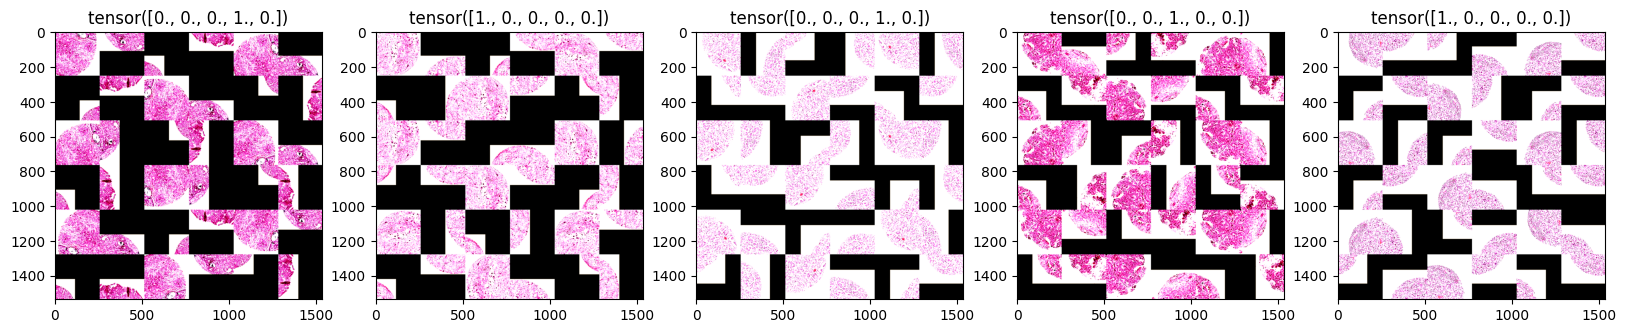

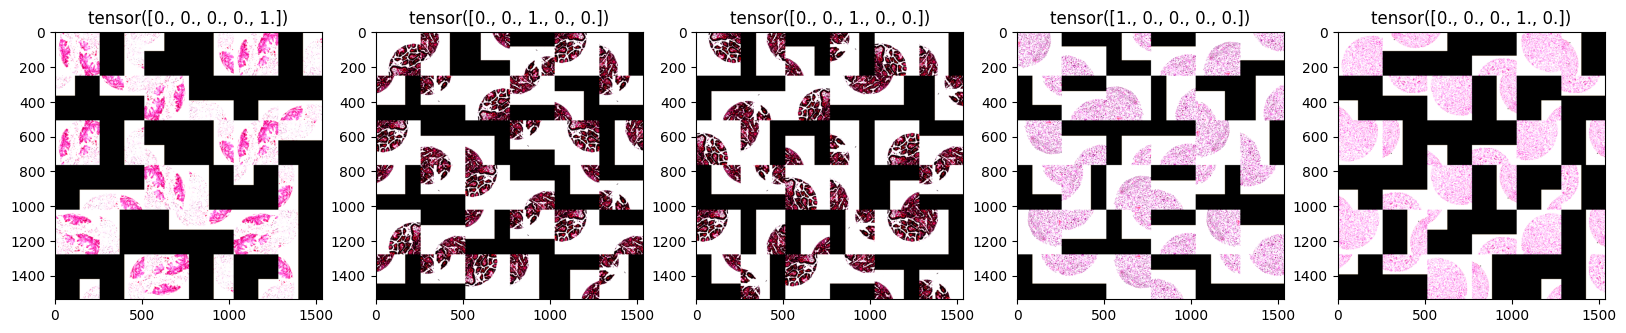

In [27]:
dataset_show = PANDADataset(df_train.query('is_tma==True'), image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(label)


# Loss

In [28]:
# labels = ['CC', 'EC', 'HGSC', 'LGSC', 'MC', 'Other'] #df_train['label'].unique().tolist() + ['Other']
# pos_weight = torch.tensor([1.0, 3.0, 3.0, 3.0, 1.0], dtype=torch.float32)
# pos_weight = pos_weight.to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

# Train and Val

In [29]:
# def train_epoch(loader, optimizer):

#     model.train()
#     train_loss = []
#     bar = tqdm(loader)
#     for (data, target) in bar:

#         data, target = data.to(device), target.to(device)
#         loss_func = criterion
#         optimizer.zero_grad()
#         logits = model(data)
#         loss = loss_func(logits, target)
#         loss.backward()
#         optimizer.step()

#         loss_np = loss.detach().cpu().numpy()
#         train_loss.append(loss_np)
#         smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
#         bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
#     return train_loss


# prompt: def train_epoch(loader, optimizer):      model.train()     train_loss = []     bar = tqdm(loader)     for (data, target) in bar:          data, target = data.to(device), target.to(device)         loss_func = criterion         optimizer.zero_grad()         logits = model(data)         loss = loss_func(logits, target)         loss.backward()         optimizer.step()          loss_np = loss.detach().cpu().numpy()         train_loss.append(loss_np)         smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)         bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))     return train_lossをtorch.autocast and torch.cuda.amp.GradScalerをつかって書き換えて

def train_epoch(loader, optimizer):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    scaler = torch.cuda.amp.GradScaler()
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(data)
            loss = loss_func(logits, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().detach()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target)

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
#     acc = (PREDS == TARGETS).mean() * 100.
    comp_metric = balanced_accuracy_score(TARGETS.argmax(1), PREDS.argmax(1))
    print(comp_metric)

#     qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
#     qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
#     qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
#     print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, comp_metric, PREDS



# Create Dataloader & Model & Optimizer

In [30]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

430 108


# Run Training

In [31]:
def mymetric(df):
    cols = df['label'].unique().tolist()
    recalls = dict()
    for col in cols:
        df_ = df.query('label==@col')
        recalls[col] = (df_['label']==df_['pred']).sum()/df_.shape[0]
    score = 0
    for k, v in recalls.items():
        score += v
    score /= len(cols)
    return score, recalls

In [32]:
%%time
comp_metric_max = 0.
best_file = os.path.join(OUTPUT_EXP, f'{kernel_type}_best_fold{fold}.pth')
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, comp_metric, oof_preds = val_epoch(valid_loader)
    df_valid['pred'] = oof_preds.argmax(1)
    df_valid['pred'] = df_valid['pred'].map(n2l)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, balanced accuracy: {(comp_metric):.5f}, '
    content += str(mymetric(df_valid))
    print(content)
    with open(os.path.join(OUTPUT_EXP, f'log_{kernel_type}.txt'), 'a') as appender:
        appender.write(content + '\n')

    if comp_metric > comp_metric_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(comp_metric_max, comp_metric))
        torch.save(model.state_dict(), best_file)
        np.save(os.path.join(OUTPUT_EXP, f'oof_preds_best_fold{fold}.npy'), oof_preds)
        comp_metric_max = comp_metric

torch.save(model.state_dict(), os.path.join(OUTPUT_EXP, f'{kernel_type}_final_fold{fold}.pth'))
np.save(os.path.join(OUTPUT_EXP, f'oof_preds_final_fold{fold}.npy'), oof_preds)
print(f'comp metric max {comp_metric_max}')

Sun Dec 10 05:41:55 2023 Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://githu

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.38066666666666665
Sun Dec 10 05:59:51 2023 Epoch 1, lr: 0.0000300, train loss: 0.56998, val loss: 0.47233, balanced accuracy: 0.38067, (0.3806666666666667, {'HGSC': 0.9333333333333333, 'CC': 0.65, 'EC': 0.32, 'MC': 0.0, 'LGSC': 0.0})
score2 (0.000000 --> 0.380667).  Saving model ...
Sun Dec 10 05:59:51 2023 Epoch: 2


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.5311111111111111
Sun Dec 10 06:17:45 2023 Epoch 2, lr: 0.0003000, train loss: 0.36624, val loss: 0.40262, balanced accuracy: 0.53111, (0.5311111111111111, {'HGSC': 0.8444444444444444, 'CC': 0.7, 'EC': 0.0, 'MC': 0.8888888888888888, 'LGSC': 0.2222222222222222})
score2 (0.380667 --> 0.531111).  Saving model ...
Sun Dec 10 06:17:45 2023 Epoch: 3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.6284444444444445
Sun Dec 10 06:35:37 2023 Epoch 3, lr: 0.0000300, train loss: 0.33922, val loss: 0.29146, balanced accuracy: 0.62844, (0.6284444444444446, {'HGSC': 0.6888888888888889, 'CC': 0.8, 'EC': 0.32, 'MC': 1.0, 'LGSC': 0.3333333333333333})
score2 (0.531111 --> 0.628444).  Saving model ...
Sun Dec 10 06:35:37 2023 Epoch: 4


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.5753333333333334
Sun Dec 10 06:53:34 2023 Epoch 4, lr: 0.0002919, train loss: 0.30804, val loss: 0.36038, balanced accuracy: 0.57533, (0.5753333333333333, {'HGSC': 0.5111111111111111, 'CC': 0.65, 'EC': 0.16, 'MC': 1.0, 'LGSC': 0.5555555555555556})
Sun Dec 10 06:53:34 2023 Epoch: 5


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.6771111111111111
Sun Dec 10 07:12:01 2023 Epoch 5, lr: 0.0002819, train loss: 0.29752, val loss: 0.32049, balanced accuracy: 0.67711, (0.6771111111111111, {'HGSC': 0.8, 'CC': 0.75, 'EC': 0.28, 'MC': 1.0, 'LGSC': 0.5555555555555556})
score2 (0.628444 --> 0.677111).  Saving model ...
Sun Dec 10 07:12:01 2023 Epoch: 6


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7333333333333334
Sun Dec 10 07:30:02 2023 Epoch 6, lr: 0.0002684, train loss: 0.26810, val loss: 0.26987, balanced accuracy: 0.73333, (0.7333333333333334, {'HGSC': 0.7111111111111111, 'CC': 0.8, 'EC': 0.6, 'MC': 1.0, 'LGSC': 0.5555555555555556})
score2 (0.677111 --> 0.733333).  Saving model ...
Sun Dec 10 07:30:02 2023 Epoch: 7


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7415555555555555
Sun Dec 10 07:47:59 2023 Epoch 7, lr: 0.0002516, train loss: 0.23710, val loss: 0.23915, balanced accuracy: 0.74156, (0.7415555555555555, {'HGSC': 0.7333333333333333, 'CC': 0.85, 'EC': 0.68, 'MC': 0.8888888888888888, 'LGSC': 0.5555555555555556})
score2 (0.733333 --> 0.741556).  Saving model ...
Sun Dec 10 07:48:00 2023 Epoch: 8


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.6788888888888889
Sun Dec 10 08:06:11 2023 Epoch 8, lr: 0.0002320, train loss: 0.21544, val loss: 0.27190, balanced accuracy: 0.67889, (0.6788888888888889, {'HGSC': 0.7333333333333333, 'CC': 0.75, 'EC': 0.8, 'MC': 0.7777777777777778, 'LGSC': 0.3333333333333333})
Sun Dec 10 08:06:11 2023 Epoch: 9


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7351111111111112
Sun Dec 10 08:24:26 2023 Epoch 9, lr: 0.0002103, train loss: 0.20271, val loss: 0.27632, balanced accuracy: 0.73511, (0.735111111111111, {'HGSC': 0.7111111111111111, 'CC': 0.8, 'EC': 0.72, 'MC': 0.8888888888888888, 'LGSC': 0.5555555555555556})
Sun Dec 10 08:24:26 2023 Epoch: 10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.8091111111111111
Sun Dec 10 08:42:39 2023 Epoch 10, lr: 0.0001868, train loss: 0.17894, val loss: 0.22255, balanced accuracy: 0.80911, (0.8091111111111111, {'HGSC': 0.8, 'CC': 0.85, 'EC': 0.84, 'MC': 0.8888888888888888, 'LGSC': 0.6666666666666666})
score2 (0.741556 --> 0.809111).  Saving model ...
Sun Dec 10 08:42:40 2023 Epoch: 11


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7197777777777778
Sun Dec 10 09:00:49 2023 Epoch 11, lr: 0.0001624, train loss: 0.14696, val loss: 0.31508, balanced accuracy: 0.71978, (0.7197777777777778, {'HGSC': 0.6444444444444445, 'CC': 0.95, 'EC': 0.56, 'MC': 1.0, 'LGSC': 0.4444444444444444})
Sun Dec 10 09:00:49 2023 Epoch: 12


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7826666666666666
Sun Dec 10 09:18:44 2023 Epoch 12, lr: 0.0001376, train loss: 0.15486, val loss: 0.22634, balanced accuracy: 0.78267, (0.7826666666666666, {'HGSC': 0.7777777777777778, 'CC': 0.9, 'EC': 0.68, 'MC': 1.0, 'LGSC': 0.5555555555555556})
Sun Dec 10 09:18:44 2023 Epoch: 13


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7566666666666666
Sun Dec 10 09:36:59 2023 Epoch 13, lr: 0.0001132, train loss: 0.13429, val loss: 0.24655, balanced accuracy: 0.75667, (0.7566666666666666, {'HGSC': 0.6888888888888889, 'CC': 0.85, 'EC': 0.8, 'MC': 0.7777777777777778, 'LGSC': 0.6666666666666666})
Sun Dec 10 09:36:59 2023 Epoch: 14


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7762222222222223
Sun Dec 10 09:55:01 2023 Epoch 14, lr: 0.0000897, train loss: 0.12216, val loss: 0.26450, balanced accuracy: 0.77622, (0.7762222222222223, {'HGSC': 0.7555555555555555, 'CC': 0.85, 'EC': 0.72, 'MC': 1.0, 'LGSC': 0.5555555555555556})
Sun Dec 10 09:55:01 2023 Epoch: 15


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7742222222222223
Sun Dec 10 10:13:15 2023 Epoch 15, lr: 0.0000680, train loss: 0.10982, val loss: 0.26214, balanced accuracy: 0.77422, (0.7742222222222223, {'HGSC': 0.7555555555555555, 'CC': 0.8, 'EC': 0.76, 'MC': 1.0, 'LGSC': 0.5555555555555556})
Sun Dec 10 10:13:15 2023 Epoch: 16


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.762
Sun Dec 10 10:31:51 2023 Epoch 16, lr: 0.0000484, train loss: 0.09349, val loss: 0.24983, balanced accuracy: 0.76200, (0.7620000000000001, {'HGSC': 0.7555555555555555, 'CC': 0.85, 'EC': 0.76, 'MC': 0.8888888888888888, 'LGSC': 0.5555555555555556})
Sun Dec 10 10:31:51 2023 Epoch: 17


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7548888888888889
Sun Dec 10 10:50:31 2023 Epoch 17, lr: 0.0000316, train loss: 0.08559, val loss: 0.26078, balanced accuracy: 0.75489, (0.7548888888888889, {'HGSC': 0.6888888888888889, 'CC': 0.85, 'EC': 0.68, 'MC': 1.0, 'LGSC': 0.5555555555555556})
Sun Dec 10 10:50:31 2023 Epoch: 18


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7875555555555556
Sun Dec 10 11:09:05 2023 Epoch 18, lr: 0.0000181, train loss: 0.07530, val loss: 0.23754, balanced accuracy: 0.78756, (0.7875555555555556, {'HGSC': 0.8222222222222222, 'CC': 0.8, 'EC': 0.76, 'MC': 1.0, 'LGSC': 0.5555555555555556})
Sun Dec 10 11:09:05 2023 Epoch: 19


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7611111111111112
Sun Dec 10 11:27:47 2023 Epoch 19, lr: 0.0000081, train loss: 0.07899, val loss: 0.24164, balanced accuracy: 0.76111, (0.7611111111111111, {'HGSC': 0.7111111111111111, 'CC': 0.85, 'EC': 0.8, 'MC': 0.8888888888888888, 'LGSC': 0.5555555555555556})
Sun Dec 10 11:27:47 2023 Epoch: 20


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.7566666666666666
Sun Dec 10 11:46:18 2023 Epoch 20, lr: 0.0000020, train loss: 0.07854, val loss: 0.26501, balanced accuracy: 0.75667, (0.7566666666666666, {'HGSC': 0.6888888888888889, 'CC': 0.85, 'EC': 0.8, 'MC': 0.8888888888888888, 'LGSC': 0.5555555555555556})
comp metric max 0.8091111111111111
CPU times: user 17min 3s, sys: 2min 37s, total: 19min 41s
Wall time: 6h 4min 23s
